In [158]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import numpy as np
import pandas as pd

from paths import DATA_PATH

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer

import torch

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

import gymnasium as gym
import numpy as np
import pandas as pd
import pygame
from gymnasium import spaces
from gymnasium.envs.registration import register
from gymnasium.spaces import Box
from gymnasium.spaces import Discrete

from torch.utils.data import Dataset, DataLoader
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from utils import stock_possible_profit_percent_score, stock_option_accuracy_score


In [2]:
df = pd.read_csv(DATA_PATH / 'news_stocks.csv')
df = df.reindex(index=df.index[::-1]).reset_index(drop=True)
df

,date,title,text,link,author,label,open,high,low,close,volume
0,2022-05-08,Заявки на транзит российского газа через Украи...,На уровне более 90 миллионов кубометров заявки...,https://www.finam.ru/publications/item/zayavki...,РИА Новости,positive,124.30,126.41,120.90,121.11,580965.0
1,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,580965.0
2,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,580965.0
3,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,580965.0
4,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,580965.0
...,...,...,...,...,...,...,...,...,...,...,...
30609,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,11352.0
30610,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,11352.0
30611,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,11352.0
30612,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,11352.0


In [3]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
def embed_bert_cls(text, model, tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    return model_output.pooler_output

In [5]:
title_texts = df.title.fillna('') + df.text.fillna('')
title_texts[:10]

0    Заявки на транзит российского газа через Украи...
1    Юань - хороший инструмент для хеджирования рис...
2    "Сбербанк" увеличил сумму кредита по ипотеке с...
3    Постпреды ЕС в воскресенье не достигли соглаше...
4    Реальные доходы россиян в 2022 году могут упас...
5    США ввели санкции против трех российских телек...
6    Страны G7 договорились сократить импорт нефти ...
7    Минфин США предписал завершить бухгалтерские у...
8    Что будет дальше с рублем? Когда состав участн...
9    Азиатские индексы и нефть снижаются Рубль на м...
dtype: object

In [28]:
embeddings1 = embed_bert_cls(title_texts[:1000].to_list(), model, tokenizer)
embeddings1

tensor([[ 0.2359, -0.2675, -0.4598,  ...,  0.0712,  0.1842, -0.2360],
        [-0.0711, -0.1090, -0.3357,  ..., -0.1869,  0.0874,  0.0272],
        [ 0.1478, -0.1827, -0.5571,  ..., -0.0490,  0.3434, -0.1913],
        ...,
        [-0.0674, -0.0692, -0.0982,  ..., -0.0121, -0.1205, -0.0416],
        [-0.1044, -0.2086, -0.2532,  ...,  0.0576,  0.0977, -0.2665],
        [ 0.1249, -0.3633, -0.4025,  ..., -0.0842, -0.0392, -0.3701]])

In [31]:
embeddings_map = {}

In [32]:
l = list(range(0, len(df), 1000))
l.append(len(df))

for a, b in tqdm(list(zip(l[:-1], l[1:]))):
    if (a, b) in embeddings_map:
        continue
    embeddings_map[(a, b)] = embed_bert_cls(title_texts[a:b].to_list(), model, tokenizer)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [01:41<00:00,  3.26s/it]


In [34]:
all_embeddings = torch.cat(tuple(embeddings_map.values()))

In [83]:
emb_len = all_embeddings.shape[1]
emb_len

312

In [84]:
emb_cols = [f'e_{i}' for i in range(emb_len)]

In [81]:
df[emb_cols] = all_embeddings
    

/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_53865/2262925440.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'e_{i}' for i in range(emb_len)]] = all_embeddings
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_53865/2262925440.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[[f'e_{i}' for i in range(emb_len)]] = all_embeddings
/var/folders/4z/tbymbl2s59dcpbxbxz0j0ys40000gn/T/ipykernel_53865/2262925440.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

In [293]:
df

,date,title,text,link,author,label,open,high,low,close,...,e_302,e_303,e_304,e_305,e_306,e_307,e_308,e_309,e_310,e_311
0,2022-05-08,Заявки на транзит российского газа через Украи...,На уровне более 90 миллионов кубометров заявки...,https://www.finam.ru/publications/item/zayavki...,РИА Новости,positive,124.30,126.41,120.90,121.11,...,0.103771,0.202257,0.373246,0.109817,-0.359344,-0.168829,0.163244,0.071227,0.184219,-0.235952
1,2022-05-08,Юань - хороший инструмент для хеджирования рис...,Ввиду сильной экономики Китая юань менее подве...,https://www.finam.ru/publications/item/yuan-xo...,"Жильников Егор, ""Промсвязьбанк""",positive,124.30,126.41,120.90,121.11,...,0.191417,-0.144668,-0.034335,0.458479,-0.321775,-0.110197,0.122042,-0.186873,0.087409,0.027224
2,2022-05-08,"""Сбербанк"" увеличил сумму кредита по ипотеке с...",Сумма кредита по ипотеке с господдержкой увели...,https://www.finam.ru/publications/item/sberban...,Finam.ru,positive,124.30,126.41,120.90,121.11,...,0.093934,0.030167,0.302454,0.182184,-0.351135,-0.288110,0.191816,-0.049004,0.343432,-0.191289
3,2022-05-08,Постпреды ЕС в воскресенье не достигли соглаше...,Венгрия продолжает блокировать предложение Евр...,https://www.finam.ru/publications/item/postpre...,РИА Новости,negative,124.30,126.41,120.90,121.11,...,0.194146,-0.148929,-0.129475,0.364146,-0.192472,-0.341897,0.015058,-0.212334,0.202024,0.099008
4,2022-05-08,Реальные доходы россиян в 2022 году могут упас...,По отношению к пиковому 2013 году реальные рас...,https://www.finam.ru/publications/item/realnye...,"Суворов Евгений, банк ""ЦентроКредит""",negative,124.30,126.41,120.90,121.11,...,0.355723,0.054007,0.260133,0.077800,-0.209399,0.053173,0.073869,0.104973,0.006540,-0.423789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30609,2023-05-06,Результаты Ford по итогам прошедшего года можн...,Компания явно демонстрирует постепенное урегул...,https://www.finam.ru/publications/item/rezulta...,"Поздняков Дмитрий, Freedom Finance Global",positive,235.83,240.93,233.42,237.06,...,0.010785,-0.328246,-0.059159,0.314390,-0.072143,0.095185,0.080837,-0.145120,-0.185263,-0.333916
30610,2023-05-06,"Банки США - депозиты сокращаются, кредиты растут",Ребалансировка балансов банков продолжается,https://www.finam.ru/publications/item/banki-s...,Сусин Егор,negative,235.83,240.93,233.42,237.06,...,0.251259,-0.250108,0.042570,0.022726,-0.080638,0.135844,0.021528,-0.120701,-0.184782,-0.255690
30611,2023-05-06,"Закрытие дивидендного реестра по ""Сбербанку"" с...",Последний день с рекордными дивидендами акции ...,https://www.finam.ru/publications/item/zakryti...,"Кожухова Елена, ИК ""Велес Капитал""",positive,235.83,240.93,233.42,237.06,...,-0.000242,-0.204710,0.134885,0.177999,-0.032256,-0.091977,0.143537,-0.167959,-0.051102,-0.271462
30612,2023-05-06,Встреча по зерновой сделке на уровне заместите...,"Встреча пройдет с участием России, Украины, Ту...",https://www.finam.ru/publications/item/vstrech...,Finam.ru,positive,235.83,240.93,233.42,237.06,...,0.148061,-0.046843,-0.167738,0.312058,-0.254814,-0.418531,0.190579,-0.199932,0.387920,0.232320


In [294]:
target_df = pd.concat([
    df[emb_cols],
    df.high,
    df.low,
    df.volume,
    df.open,                  
    df.close], axis=1)
target_df

,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9,...,e_307,e_308,e_309,e_310,e_311,high,low,volume,open,close
0,0.235935,-0.267507,-0.459825,0.247621,0.060827,0.252349,0.151447,-0.369153,-0.081369,-0.050413,...,-0.168829,0.163244,0.071227,0.184219,-0.235952,126.41,120.90,580965.0,124.30,121.11
1,-0.071100,-0.108975,-0.335740,0.173969,-0.055430,0.262379,-0.210006,0.061716,-0.021734,0.164603,...,-0.110197,0.122042,-0.186873,0.087409,0.027224,126.41,120.90,580965.0,124.30,121.11
2,0.147772,-0.182699,-0.557074,0.232361,0.022831,0.055627,0.010512,-0.335945,-0.230046,0.201516,...,-0.288110,0.191816,-0.049004,0.343432,-0.191289,126.41,120.90,580965.0,124.30,121.11
3,-0.036737,0.120419,-0.158517,0.391521,-0.094405,0.040762,-0.030951,-0.111376,0.159205,0.400714,...,-0.341897,0.015058,-0.212334,0.202024,0.099008,126.41,120.90,580965.0,124.30,121.11
4,0.134210,-0.387117,-0.500637,0.026435,0.163425,0.405951,-0.038941,-0.170006,-0.079694,-0.045553,...,0.053173,0.073869,0.104973,0.006540,-0.423789,126.41,120.90,580965.0,124.30,121.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30609,0.033912,-0.372742,-0.303525,0.053621,0.011476,0.213031,-0.295061,0.141496,-0.085785,0.204877,...,0.095185,0.080837,-0.145120,-0.185263,-0.333916,240.93,233.42,11352.0,235.83,237.06
30610,-0.201371,-0.358950,-0.396723,0.113423,0.145470,0.132511,-0.129492,0.152106,0.153315,0.010532,...,0.135844,0.021528,-0.120701,-0.184782,-0.255690,240.93,233.42,11352.0,235.83,237.06
30611,0.096429,-0.339360,-0.361345,-0.023941,0.083173,0.102811,-0.133787,0.016019,-0.130618,0.117193,...,-0.091977,0.143537,-0.167959,-0.051102,-0.271462,240.93,233.42,11352.0,235.83,237.06
30612,0.189556,0.054599,-0.301796,0.461080,-0.176824,-0.204224,-0.119848,-0.111970,0.006975,0.430336,...,-0.418531,0.190579,-0.199932,0.387920,0.232320,240.93,233.42,11352.0,235.83,237.06


In [295]:
target='close'
features=list(target_df.columns)[:-1]
test_size = 0.22
n_samples = target_df.shape[0]


scaler = MinMaxScaler()

target_df = pd.DataFrame(scaler.fit_transform(target_df), columns=target_df.columns)


df_train = target_df[:n_samples - int(n_samples * test_size)]
df_test = target_df[-int(n_samples * test_size):]

df_test

,e_0,e_1,e_2,e_3,e_4,e_5,e_6,e_7,e_8,e_9,...,e_307,e_308,e_309,e_310,e_311,high,low,volume,open,close
23879,0.415202,0.373276,0.577296,0.500449,0.445321,0.810832,0.304127,0.583027,0.765463,0.548410,...,0.583081,0.427981,0.342593,0.363900,0.352318,0.435979,0.479133,0.082915,0.463896,0.453531
23880,0.629631,0.192228,0.269996,0.542468,0.449463,0.858673,0.372803,0.580227,0.722998,0.578496,...,0.518616,0.733122,0.268442,0.418740,0.287901,0.435979,0.479133,0.082915,0.463896,0.453531
23881,0.530040,0.248156,0.501914,0.369988,0.638685,0.738345,0.308323,0.646684,0.593038,0.448212,...,0.664404,0.530131,0.377503,0.235366,0.312903,0.435979,0.479133,0.082915,0.463896,0.453531
23882,0.473949,0.265475,0.472064,0.323120,0.493550,0.808443,0.379651,0.621113,0.631711,0.369738,...,0.615433,0.596502,0.448057,0.250829,0.354457,0.435979,0.479133,0.082915,0.463896,0.453531
23883,0.832978,0.148319,0.162378,0.173737,0.644728,0.893046,0.472756,0.447845,0.463049,0.308927,...,0.472703,0.640753,0.411121,0.458371,0.143214,0.435979,0.479133,0.082915,0.463896,0.453531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30609,0.580836,0.232927,0.351550,0.452259,0.547359,0.767027,0.273416,0.619203,0.508746,0.584767,...,0.617077,0.627681,0.347868,0.321997,0.263758,0.974959,0.964655,0.002917,0.951839,0.960996
30610,0.332575,0.246495,0.258778,0.507616,0.726511,0.681724,0.439579,0.628416,0.765625,0.367002,...,0.652973,0.539876,0.374410,0.322431,0.333403,0.974959,0.964655,0.002917,0.951839,0.960996
30611,0.646802,0.265767,0.293994,0.380461,0.643218,0.650260,0.435269,0.510239,0.460579,0.486516,...,0.451843,0.720506,0.323044,0.443184,0.319361,0.974959,0.964655,0.002917,0.951839,0.960996
30612,0.745066,0.653335,0.353271,0.829437,0.295599,0.324990,0.449258,0.399092,0.608403,0.837396,...,0.163548,0.790151,0.288291,0.839752,0.767880,0.974959,0.964655,0.002917,0.951839,0.960996


In [296]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]


In [351]:
torch.manual_seed(101)

sequence_length = 42

batch_size = 100

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([100, 42, 316])
Target shape: torch.Size([100])


In [352]:
from torch.autograd import Variable

class DQNLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes=1):
        super().__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size=input_size, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [353]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [354]:
class StocksEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, df, fail_difference_threshold, max_difference_for_reward=0.01, render_mode=None, size=5, fps=4):
        self.size = size
        self.window_size = 512

        self._fail_difference_threshold = fail_difference_threshold
        self._max_difference_for_reward = max_difference_for_reward
    
        self._original_df = df

        X = df.iloc[:, :-1]
        self._X = X
        y = df.iloc[:, -1]
        self._y = y
        
        self._taget_column_name = self._y.name
        
                
        self._action_indent = 1e-3
        action_min = y.min() - self._action_indent
        self._action_min = action_min
        action_max = y.max() + self._action_indent
        self._action_max = action_max    

        self._initial_taget_location = y.iloc[0]
        
        feature_number = X.shape[1]

        self._dataset = SequenceDataset(
            df,
            target='close',
            features=features,
            sequence_length=sequence_length,
        )
        
        #observing current state of market and news
        describe = X.describe()
        self.observation_space = spaces.Box(
            low=describe.loc['min'].to_numpy(),
            high=describe.loc['max'].to_numpy(),
            shape=(feature_number,), dtype=np.float32
        )

        # prediction of close price
#         self.action_space = spaces.Box(
#             low=-max_action_bound, 
#             high=+max_action_bound,
#             dtype=np.float32,
#         )
        # prediction to buy or to sell relatively
        self.action_space = spaces.Discrete(3)
        target_std = self._y.std()
        shift = target_std / 100
        self._action_to_shift = {
            0: np.array([0]),
            1: shift,
            2: -shift,
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        self.window = None
        self.clock = None

    def _get_obs(self):
        features, target = self._dataset[self._current_dataset_idx]
        return features

    def _get_info(self):
        return self._current_dataset_idx
    

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        self._agent_history = []

#         self._agent_location = self.np_random.integers(self._obs_min, self._obs_max, size=1, dtype=np.float32)
        self._agent_location = np.array([self._initial_taget_location])

        self._target_location = np.array([self._initial_taget_location])
        
        self._current_dataset_idx = 0

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        self._reward_count = 0

        return observation, info

    def step(self, action):
        shift = self._action_to_shift[action]
        
        self._agent_location = np.clip(
            self._agent_location + shift, self._action_min, self._action_max
        )
        
        self._agent_history.append(self._agent_location)

        

        target = self._y.iloc[self._current_dataset_idx]

        agent_target_difference = np.abs(self._agent_location - target)

        reward = 1 if agent_target_difference < self._max_difference_for_reward else 0
        
        self._reward_count += reward
        
        terminated = (
            (self._current_dataset_idx >= len(self._dataset) - 1)
            or
            (agent_target_difference > self._fail_difference_threshold)
        )
    
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()
        
        self._current_dataset_idx += 1
        return observation, reward, terminated, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        target = self._y.iloc[:self._current_dataset_idx]
        agent = pd.Series(np.array(self._agent_history).flatten(), index = target.index)

        plt.figure(3)
        plt.clf()
        plt.cla()
        plt.plot(target, label='target')
        plt.plot(agent, label='agent')
        
        plt.title("%s | Step: %d | Reward: %d" % (env, self._current_dataset_idx, self._reward_count))
#         plt.ylim((target.min()-0, target.max()+0))
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()


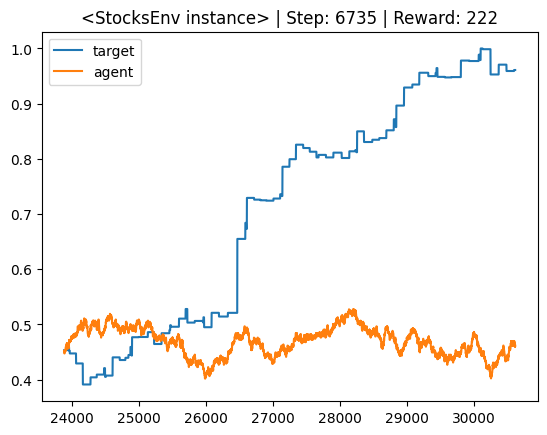

torch.Size([42, 316])


In [355]:
env = StocksEnv(df_test, fail_difference_threshold=2.5, render_mode="rgb_array")


observation, info = env.reset(seed=42)


for i in range(1000000):
    action = env.action_space.sample()
#     action = 0
    
    observation, reward, terminated, truncated, info = env.step(action)
    if i % 1000 == 0:
#         env.render()
        pass

    if terminated or truncated:
        env.render()
        observation, info = env.reset()
        print(observation.shape)
        break


env.close()

In [356]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [357]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4


env = StocksEnv(
    target_df, 
    fail_difference_threshold=0.05, 
    max_difference_for_reward=0.001,
    render_mode="rgb_array"
)


n_actions = env.action_space.n

state, info = env.reset()
n_observations = len(state)

hidden_size = 42
num_layers = 1

policy_net = DQNLSTM(
    input_size=len(features), 
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    num_classes=n_actions,
).to(device).to(device)
target_net = DQNLSTM(
    input_size=len(features), 
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    num_classes=n_actions,
).to(device).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []
rewards = []


def plot_durations(show_result=False):
    fig, axs = plt.subplots(2, 1, figsize=(10,5))
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    eps_plt = axs[0]
    if show_result:
        eps_plt.set_title('Result')
    else:
        plt.clf()
        eps_plt.title('Training...')

#     eps_plt.set_xlabel('Episode')
    eps_plt.set_ylabel('Duration')
    eps_plt.plot(durations_t.numpy(), label='durations')
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        eps_plt.plot(means.numpy(), label='mean durations')
    
    rewards_plt = axs[1]
    rewards_plt.plot(rewards, label='reward', c='r')
    rewards_plt.set_xlabel('Episode')
    rewards_plt.set_ylabel('Reward')
    fig.legend()
    
    plt.pause(0.001)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

if torch.cuda.is_available():
    num_episodes = 6000
else:
    num_episodes = 5000

/Users/ruslansirazhetdinov/Documents/MIPT/Учеба/nlpystocks/.venv.nosync/lib/python3.11/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
env = StocksEnv(
    target_df, 
    fail_difference_threshold=0.05, 
    max_difference_for_reward=0.001,
    render_mode="rgb_array"
)
t=0
for i_episode in range(num_episodes):
    print('EPISODE', i_episode)
    print('LAST FAIL', t)
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    reward_count = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward_count += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward)

        state = next_state

        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        
        if (t+1) % 1000 == 0:
            print(t)
#             env.render()

        if done:
            episode_durations.append(t + 1)
            rewards.append(reward_count)
#             plot_durations(show_result=True)
            env.render()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

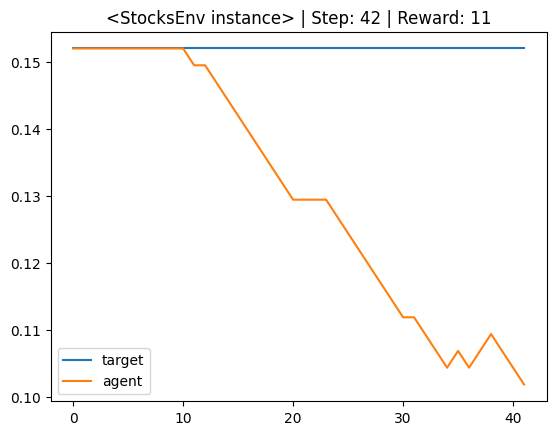

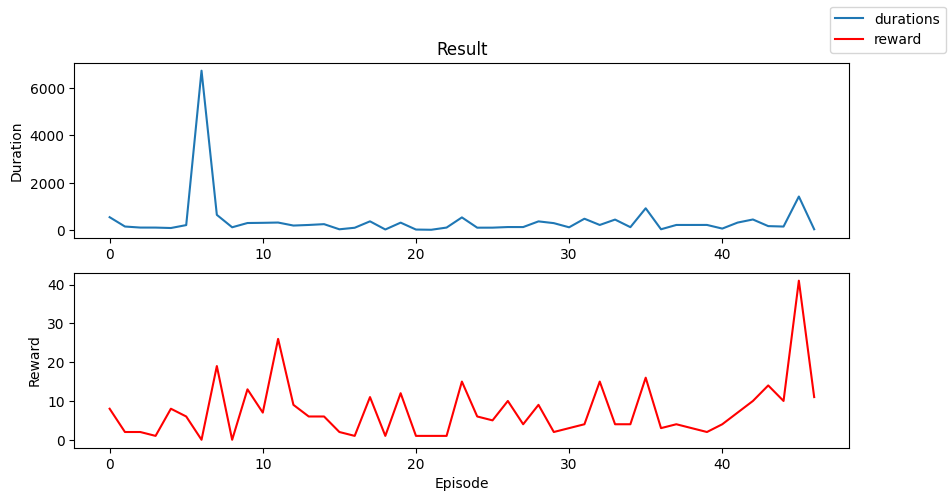

In [362]:
plot_durations(show_result=True)

In [ ]:
env_df = df_test

env = StocksEnv(
    env_df, 
    fail_difference_threshold=1, 
    max_difference_for_reward=0.001,
    render_mode="rgb_array"
)

state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
reward_count = 0
for t in count():
    with torch.no_grad():
        action = policy_net(state).max(1)[1].view(1, 1)
    observation, reward, terminated, truncated, _ = env.step(action.item())
    reward_count += reward
    reward = torch.tensor([reward], device=device)
    done = terminated or truncated

    if terminated:
        next_state = None
    else:
        next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

#     memory.push(state, action, next_state, reward)
    state = next_state


    if (t+1) % 1000 == 0:
        print(t)
        env.render()

    if done:
        episode_durations.append(t + 1)
        rewards.append(reward_count)
#             plot_durations(show_result=True)
        env.render()
        break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [364]:
def running_mean(x, N,mode='valid'):
    return np.convolve(x, np.ones((N,))/N, mode=mode)

def model_results(env_df, moving_average=None):
    env_df = prepare_results(env_df)
    y_test = env_df['close']
    y_test_pred = env_df[predict_col]
    print('Test MSE', mean_squared_error(y_test, y_test_pred))
    print('Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred))
    print('Test SOAS', stock_option_accuracy_score(df, y_true=y_test, y_pred=pd.Series(y_test_pred, index=y_test.index)))
    print('Test S3PS', stock_possible_profit_percent_score(df, y_true=y_test, y_pred=pd.Series(y_test_pred, index=y_test.index)))

    y_pred = env_df[predict_col]
    y = env_df['close']
    if moving_average:
        y_pred = running_mean(y_pred, moving_average)
        
        y_test_pred_smooth = running_mean(y_test_pred, moving_average, mode='same')
        print('Smoothed Test MSE', mean_squared_error(y_test, y_test_pred_smooth))
        print('Smoothed Test MAPE', mean_absolute_percentage_error(y_test, y_test_pred_smooth))
        print('Smoothed Test SOAS', stock_option_accuracy_score(df, y_true=y_test, y_pred=pd.Series(y_test_pred_smooth, index=y_test.index)))
        print('Smoothed Test S3PS', stock_possible_profit_percent_score(df, y_true=y_test, y_pred=pd.Series(y_test_pred_smooth, index=y_test.index)))
        
    
    fig, ax = plt.subplots(1,1)
    train_size = len(df_train)
    y_pred = pd.Series(y_pred)
    ax.plot(y, label='true')
    ax.plot(y_pred, label='pred')
    ax.set_ylim((y.min()-10, y.max()+10))
#     plt.axvline(x=train_size, c='r', linestyle='--')
    ax.legend()
    plt.show()
    
def prepare_results(env_df):
    env_df = env_df.copy()
    sc = MinMaxScaler()
    sc.min_, sc.scale_ = scaler.min_[-1], scaler.scale_[-1]

    target_arr = env._y.iloc[:env._current_dataset_idx].to_numpy()[:,np.newaxis]
    target_arr = sc.inverse_transform(target_arr)
    env_df[target] = target_arr
    agent = np.array(env._agent_history).flatten()[:,np.newaxis]
    agent = sc.inverse_transform(agent)
    predict_col='agent'
    env_df[predict_col] = agent
    return env_df

Test MSE 166.67163537761755
Test MAPE 0.05134015350531124
Test SOAS 0.56
Test S3PS 7.333128986263029


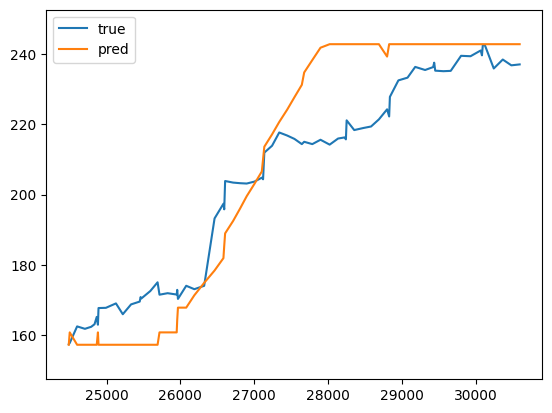

In [365]:
model_results(moving_average=None)